<a href="https://colab.research.google.com/github/hanan000/Simple-data-scraping/blob/master/News_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd/content/drive/MyDrive/news

/content/drive/MyDrive/news


In [ ]:
!pip install  rouge-score

In [ ]:
pip install rouge


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import re
import pickle

### Loading Data

In [ ]:
news = pd.read_excel("/content/drive/MyDrive/news/news.xlsx")

In [ ]:
news.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)

In [ ]:
news.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [ ]:
news.shape

(55104, 2)

In [ ]:
news_train = pd.read_csv("/content/drive/MyDrive/news/Train_news.csv")
news_train.head()

,Text,summary
0,The CBI on Saturday booked four former officia...,4 ex-bank officials booked for cheating bank o...
1,Chief Justice JS Khehar has said the Supreme C...,Supreme Court to go paperless in 6 months: CJI
2,"At least three people were killed, including a...","At least 3 killed, 30 injured in blast in Sylh..."
3,Mukesh Ambani-led Reliance Industries (RIL) wa...,Why has Reliance been barred from trading in f...
4,TV news anchor Arnab Goswami has said he was t...,Was stopped from entering my own studio at Tim...


In [ ]:
news_train.shape

(54104, 2)

In [ ]:
news_test= pd.read_csv("/content/drive/MyDrive/news/Test_news.csv")
news_test.head()

,Text,summary
0,The All India Congress Committee has sought re...,AICC seeks report on minister transferring cop
1,At least eight people were reportedly killed a...,"Eight dead, 28 injured in bomb attack in Nigeria"
2,DMK leader MK Stalin on Thursday ridiculed Tam...,DMK&#39;s Stalin ridicules TN CM&#39;s Amma ca...
3,Google in America is reportedly testing solar-...,Google testing solar-powered drones for 5G
4,BJP leader Shatrughan Sinha on Friday criticis...,Shatrughan Sinha slams BJP in Arunachal issue


In [ ]:
news_test.shape

(1000, 2)

In [ ]:
test_articles = len(news_test)
train_articles = len(news_train)
total_articles = train_articles + test_articles
print(100*'-' + '\n')
print(f'Number of train samples: {train_articles:,} ({train_articles/total_articles:.1%}) \n' 
        f'Number of test samples: {test_articles:,} ({test_articles/total_articles:.1%})\n'
        f'Total samples {total_articles:,} ({total_articles/total_articles:0.0%})\n') 

----------------------------------------------------------------------------------------------------

Number of train samples: 54,104 (98.2%) 
Number of test samples: 1,000 (1.8%)
Total samples 55,104 (100%)



In [ ]:
summaryrtest=news_test['summary']
documenttest=news_test['Text']

In [ ]:
# since < and > from default tokens cannot be removed
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

In [ ]:
document_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

In [ ]:
document_tokenizer.fit_on_texts(documenttest)
summary_tokenizer.fit_on_texts(summaryrtest)

In [ ]:
inputs = document_tokenizer.texts_to_sequences(documenttest)
targets = summary_tokenizer.texts_to_sequences(summaryrtest)

In [ ]:
inputs_ = document_tokenizer.sequences_to_texts(inputs)
targets_ = summary_tokenizer.sequences_to_texts(targets)

In [ ]:
document = news['Short']
summary = news['Headline']

In [ ]:
document[30], summary[30]

('According to the Guinness World Records, the most generations alive in a single family have been seven.  The difference between the oldest and the youngest person in the family was about 109 years, when Augusta Bunge&#39;s great-great-great-great grandson was born on January 21, 1989. The family belonged to the United States of America.',
 'The most generations alive in a single family have been 7')

### Preprocessing

In [ ]:
# for decoder sequence
summary = summary.apply(lambda x: '<go> ' + x + ' <stop>')
summary.head()

0    <go> 4 ex-bank officials booked for cheating b...
1    <go> Supreme Court to go paperless in 6 months...
2    <go> At least 3 killed, 30 injured in blast in...
3    <go> Why has Reliance been barred from trading...
4    <go> Was stopped from entering my own studio a...
Name: Headline, dtype: object

#### Tokenizing the texts into integer tokens

In [ ]:
# since < and > from default tokens cannot be removed
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

In [ ]:
document_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

In [ ]:
document_tokenizer.fit_on_texts(document)
summary_tokenizer.fit_on_texts(summary)

In [ ]:
inputs = document_tokenizer.texts_to_sequences(document)
targets = summary_tokenizer.texts_to_sequences(summary)

In [ ]:
encoder_vocab_size = len(document_tokenizer.word_index) + 1
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(76362, 29661)

#### Obtaining insights on lengths for defining maxlen

In [ ]:
document_lengths = pd.Series([len(x) for x in document])
summary_lengths = pd.Series([len(x) for x in summary])

In [ ]:
document_lengths.describe()

count    55104.000000
mean       368.003049
std         26.235510
min        280.000000
25%        350.000000
50%        369.000000
75%        387.000000
max        469.000000
dtype: float64

In [ ]:
summary_lengths.describe()

count    55104.000000
mean        63.620282
std          7.267463
min         20.000000
25%         59.000000
50%         63.000000
75%         69.000000
max         96.000000
dtype: float64

In [ ]:
# Print bin sizes and display min and max lenghts of data.
import numpy as np

bins = pd.DataFrame()
bin_split = [0,128,256,512,1024]
all_data = pd.concat([news], axis=0)
input_binned = all_data.groupby(pd.cut(document_lengths, bins=bin_split)).size()
output_binned = all_data.groupby(pd.cut(summary_lengths, bins=bin_split)).size()
bins['num_input'] = input_binned
bins['num_output'] = output_binned
bins.index.name = 'Bins'

avg_in, avg_out = document_lengths.mean(), summary_lengths.mean()
min_in, min_out = document_lengths.min(), summary_lengths.min()
max_in, max_out = document_lengths.max(), summary_lengths.max()
bins['fraction_input'] = bins.num_input/bins.num_input.sum()
bins['fraction_output'] = bins.num_output/bins.num_output.sum()
bins['cum_fraction_input'] = bins.fraction_input.cumsum()
bins['cum_fraction_output'] = bins.fraction_output.cumsum()
display(bins)
print(f'Average len input: {avg_in:.2f}\n' \
      f'Average len output: {avg_out:.2f}\n' \
      f'Max len input: {max_in}\n' \
      f'Max len output: {max_out}\n' \
      f'Min len input: {min_in}\n' \
      f'Min len output: {min_out}\n')

,num_input,num_output,fraction_input,fraction_output,cum_fraction_input,cum_fraction_output
Bins,,,,,,
"(0, 128]",0,55104,0.0,1.0,0.0,1.0
"(128, 256]",0,0,0.0,0.0,0.0,1.0
"(256, 512]",55104,0,1.0,0.0,1.0,1.0
"(512, 1024]",0,0,0.0,0.0,1.0,1.0


Average len input: 368.00
Average len output: 63.62
Max len input: 469
Max len output: 96
Min len input: 280
Min len output: 20



Figure(720x576)
0
1


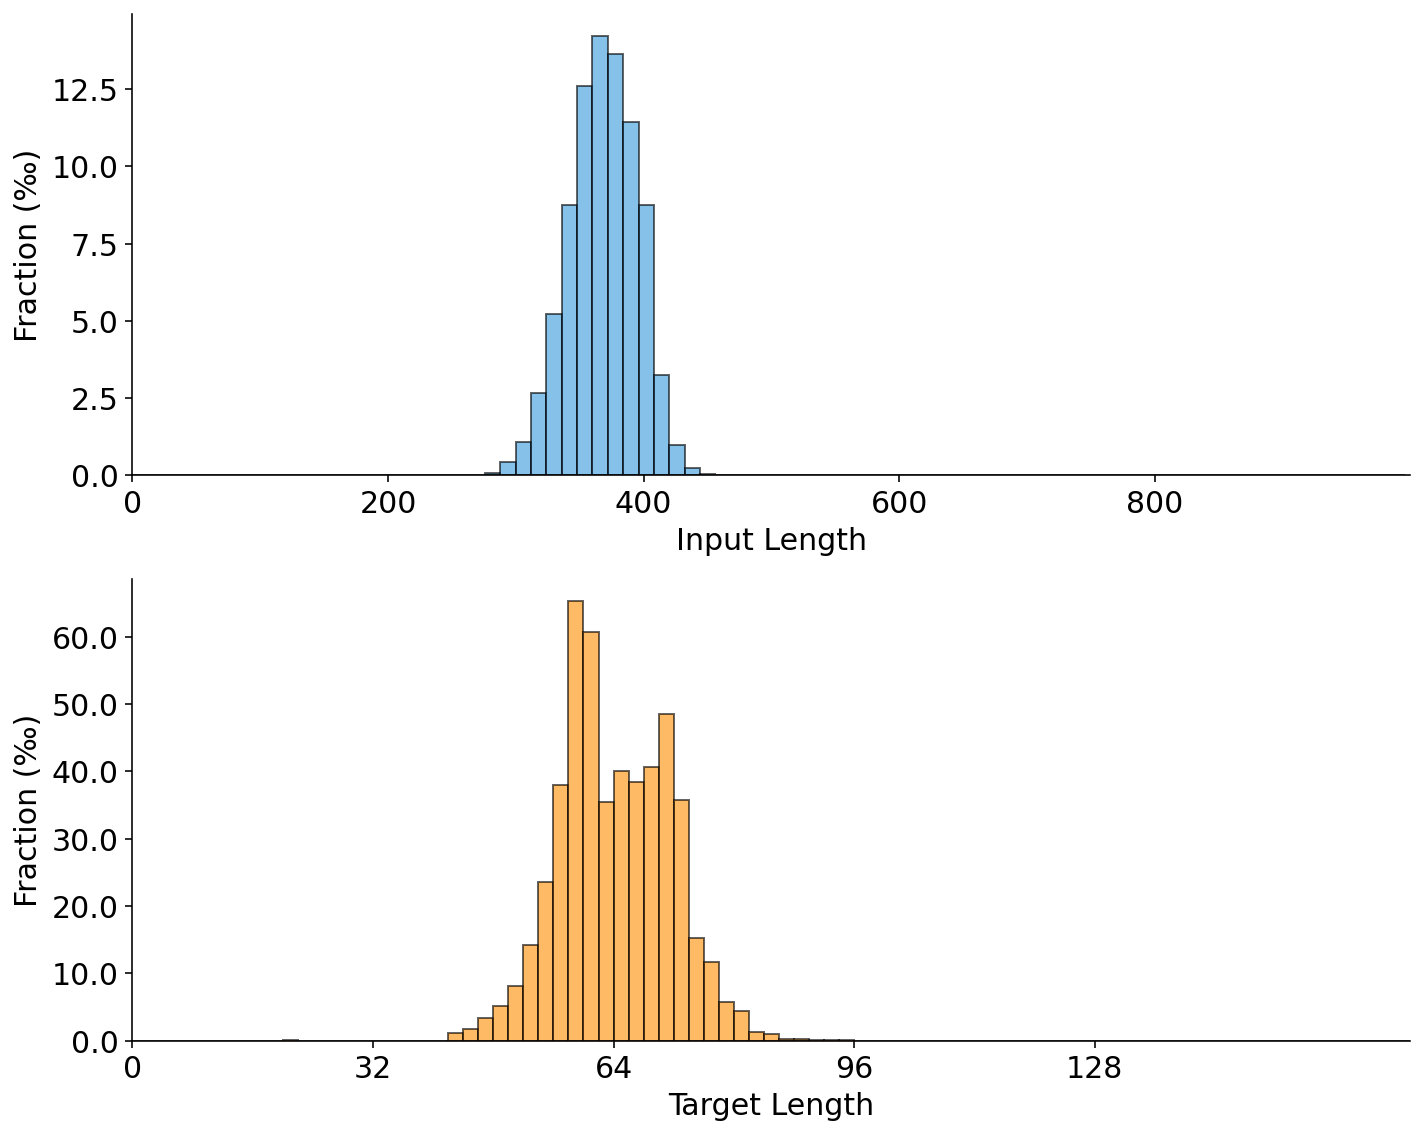

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter

import matplotlib.pyplot as plt
import matplotlib as mlt
colors = ['#3498db', '#FF8C00']

fig, ax = plt.subplots(2,1, figsize=(10,8))
print(fig)
for i, a in enumerate(ax):
    print(i)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_ylabel('Fraction (‰)', fontsize=15)
    a.tick_params(labelsize=15)
    a.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: "%.1f" % (x*1000)))

ax[0].hist(document_lengths, bins=range(0,1000,12), density=True, \
           label='input', alpha=0.6, color=colors[0], edgecolor='black')
ax[0].set_xticks(range(0,1000,200))
ax[0].set_xlim(right=1000, left=0)
ax[0].set_xlabel('Input Length', fontsize=15)

ax[1].hist(summary_lengths, bins=range(0,256,2), density=True, \
           label='targets', alpha=0.6, color=colors[1], edgecolor='black')
ax[1].set_xlim(right=170, left=0)
ax[1].set_xticks(range(0,160,32))
ax[1].set_xlabel('Target Length', fontsize=15)

fig.tight_layout()
plt.savefig('data_histogram_1.jpg')


In [ ]:
encoder_maxlen = 400
decoder_maxlen = 75

#### Padding/Truncating sequences for identical sequence lengths

In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=decoder_maxlen, padding='post', truncating='post')

### Creating dataset pipeline

In [ ]:
inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Positional Encoding for adding notion of position among words as unlike RNN this is non-directional

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


### Masking

- Padding mask for masking "pad" sequences
- Lookahead mask for masking future words from contributing in prediction of current words in self attention

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

### Building the Model

#### Scaled Dot Product

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

#### Multi-Headed Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

### Feed Forward Network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
         ])

#### Fundamental Unit of Transformer encoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


#### Fundamental Unit of Transformer decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


#### Encoder consisting of multiple EncoderLayer(s)

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x


#### Decoder consisting of multiple DecoderLayer(s)

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights


#### Finally, the Transformer

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights


### Training

In [ ]:
# hyper-params
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
EPOCHS = 40

#### Adam optimizer with custom learning rate scheduling

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


#### Defining losses and other metrics 

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

#### Transformer

In [ ]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=encoder_vocab_size, 
    pe_target=decoder_vocab_size,
)

#### Masks

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask


#### Checkpoints

In [ ]:
checkpoint_path = "/content/drive/MyDrive/checkpoints news/checkpoints 20"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(ckpt_manager.latest_checkpoint)

/content/drive/MyDrive/checkpoints news/checkpoints 20/ckpt-4


#### Training steps

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

In [ ]:
lob_2=[]
lob_1=[]

In [ ]:
EPOCHS=10

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 429 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
            lob_2.append(' {:.4f}'.format( train_loss.result()))
            lob_1.append(epoch+1)
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    lob_2.append(' {:.4f}'.format( train_loss.result()))
    lob_1.append(epoch+1)
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 10.2920
Epoch 1 Batch 429 Loss 9.1990
Epoch 1 Batch 858 Loss 8.2416
Epoch 1 Loss 8.2387
Time taken for 1 epoch: 642.039422750473 secs

Epoch 2 Batch 0 Loss 6.9647
Epoch 2 Batch 429 Loss 6.8136
Epoch 2 Batch 858 Loss 6.6158
Epoch 2 Loss 6.6148
Time taken for 1 epoch: 633.7860896587372 secs

Epoch 3 Batch 0 Loss 6.4424
Epoch 3 Batch 429 Loss 6.0943
Epoch 3 Batch 858 Loss 5.9539
Epoch 3 Loss 5.9533
Time taken for 1 epoch: 634.3277747631073 secs

Epoch 4 Batch 0 Loss 5.4645
Epoch 4 Batch 429 Loss 5.5746
Epoch 4 Batch 858 Loss 5.4829
Epoch 4 Loss 5.4824
Time taken for 1 epoch: 635.0303463935852 secs

Epoch 5 Batch 0 Loss 5.4129
Epoch 5 Batch 429 Loss 5.1904
Epoch 5 Batch 858 Loss 5.1191
Saving checkpoint for epoch 5 at checkpoints/ckpt-1
Epoch 5 Loss 5.1189
Time taken for 1 epoch: 636.3079462051392 secs

Epoch 6 Batch 0 Loss 4.7988
Epoch 6 Batch 429 Loss 4.8196
Epoch 6 Batch 858 Loss 4.7504
Epoch 6 Loss 4.7506
Time taken for 1 epoch: 636.7544088363647 secs

Epoch 7 Batc

In [ ]:
#lob2_2=[10.292, 9.199, 8.2416,8.2387, 6.9647, 6.8136, 6.6158,6.6148, 6.4424, 6.0943, 5.9539,5.9533, 5.4645, 5.5746, 5.4829, 5.4824, 5.4129, 5.1904, 5.1191,5.1189, 4.7988, 4.8196, 4.7504,4.7506 ,4.7771, 4.454, 4.4174, 4.4176,4.3338, 4.167, 4.1452,4.1452 ,3.9104, 3.9327, 3.9241,3.9238, 3.5213, 3.749, 3.7472,3.74692.6816, 2.5702, 2.613, 2.6136, 2.4739, 2.5164, 2.553, 2.5533, 2.2846, 2.4573, 2.4962, 2.4968, 2.5375, 2.3985, 2.4461, 2.447, 2.0966, 2.3493, 2.3981, 2.3981]

In [ ]:
EPOCHS=5

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 429 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
            lob_2.append(' {:.4f}'.format( train_loss.result()))
            lob_1.append(epoch+11)
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    lob_2.append(' {:.4f}'.format( train_loss.result()))
    lob_1.append(epoch+11)
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.3692
Epoch 1 Batch 429 Loss 3.5865
Epoch 1 Batch 858 Loss 3.5947
Epoch 1 Loss 3.5948
Time taken for 1 epoch: 635.6579422950745 secs

Epoch 2 Batch 0 Loss 3.5657
Epoch 2 Batch 429 Loss 3.4384
Epoch 2 Batch 858 Loss 3.4536
Epoch 2 Loss 3.4537
Time taken for 1 epoch: 634.5414414405823 secs

Epoch 3 Batch 0 Loss 3.3151
Epoch 3 Batch 429 Loss 3.3114
Epoch 3 Batch 858 Loss 3.3204
Epoch 3 Loss 3.3205
Time taken for 1 epoch: 633.8000245094299 secs

Epoch 4 Batch 0 Loss 3.0190
Epoch 4 Batch 429 Loss 3.1831
Epoch 4 Batch 858 Loss 3.2013
Epoch 4 Loss 3.2011
Time taken for 1 epoch: 633.9748780727386 secs

Epoch 5 Batch 0 Loss 2.8964
Epoch 5 Batch 429 Loss 3.0671
Epoch 5 Batch 858 Loss 3.0938
Saving checkpoint for epoch 5 at checkpoints/ckpt-3
Epoch 5 Loss 3.0942
Time taken for 1 epoch: 635.0129446983337 secs



In [ ]:
len(lob2_2)

100

In [ ]:
EPOCHS=5

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 429 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
            lob_2.append(' {:.4f}'.format( train_loss.result()))
            lob_1.append(epoch+15)
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    lob_2.append(' {:.4f}'.format( train_loss.result()))
    lob_1.append(epoch+15)
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.0377
Epoch 1 Batch 429 Loss 2.9675
Epoch 1 Batch 858 Loss 2.9932
Epoch 1 Loss 2.9932
Time taken for 1 epoch: 633.0937693119049 secs

Epoch 2 Batch 0 Loss 2.9294
Epoch 2 Batch 429 Loss 2.8774
Epoch 2 Batch 858 Loss 2.9015
Epoch 2 Loss 2.9020
Time taken for 1 epoch: 633.7147023677826 secs

Epoch 3 Batch 0 Loss 2.6298
Epoch 3 Batch 429 Loss 2.7883
Epoch 3 Batch 858 Loss 2.8246
Epoch 3 Loss 2.8246
Time taken for 1 epoch: 633.7541170120239 secs

Epoch 4 Batch 0 Loss 2.4532
Epoch 4 Batch 429 Loss 2.7074
Epoch 4 Batch 858 Loss 2.7444
Epoch 4 Loss 2.7445
Time taken for 1 epoch: 634.3033549785614 secs

Epoch 5 Batch 0 Loss 2.8274
Epoch 5 Batch 429 Loss 2.6361
Epoch 5 Batch 858 Loss 2.6776
Saving checkpoint for epoch 5 at checkpoints/ckpt-4
Epoch 5 Loss 2.6780
Time taken for 1 epoch: 635.3168087005615 secs



In [ ]:
EPOCHS=5

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 429 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
            lob_2.append(' {:.4f}'.format( train_loss.result()))
            lob_1.append(epoch+20)
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    lob_2.append(' {:.4f}'.format( train_loss.result()))
    lob_1.append(epoch+20)
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.6816
Epoch 1 Batch 429 Loss 2.5702
Epoch 1 Batch 858 Loss 2.6130
Epoch 1 Loss 2.6136
Time taken for 1 epoch: 632.464866399765 secs

Epoch 2 Batch 0 Loss 2.4739
Epoch 2 Batch 429 Loss 2.5164
Epoch 2 Batch 858 Loss 2.5530
Epoch 2 Loss 2.5533
Time taken for 1 epoch: 632.9871487617493 secs

Epoch 3 Batch 0 Loss 2.2846
Epoch 3 Batch 429 Loss 2.4573
Epoch 3 Batch 858 Loss 2.4962
Epoch 3 Loss 2.4968
Time taken for 1 epoch: 632.8553555011749 secs

Epoch 4 Batch 0 Loss 2.5375
Epoch 4 Batch 429 Loss 2.3985
Epoch 4 Batch 858 Loss 2.4461
Epoch 4 Loss 2.4470
Time taken for 1 epoch: 632.768563747406 secs

Epoch 5 Batch 0 Loss 2.0966
Epoch 5 Batch 429 Loss 2.3493
Epoch 5 Batch 858 Loss 2.3981
Saving checkpoint for epoch 5 at checkpoints/ckpt-5
Epoch 5 Loss 2.3981
Time taken for 1 epoch: 633.1824336051941 secs



In [ ]:
EPOCHS=5

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 429 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
            lob_2.append(' {:.4f}'.format( train_loss.result()))
            lob_1.append(epoch+25)
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    lob_2.append(' {:.4f}'.format( train_loss.result()))
    lob_1.append(epoch+25)
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start)) 

Epoch 1 Batch 0 Loss 2.2782
Epoch 1 Batch 429 Loss 2.3092
Epoch 1 Batch 858 Loss 2.3509
Epoch 1 Loss 2.3515
Time taken for 1 epoch: 616.2573475837708 secs

Epoch 2 Batch 0 Loss 2.1259
Epoch 2 Batch 429 Loss 2.2649
Epoch 2 Batch 858 Loss 2.3103
Epoch 2 Loss 2.3111
Time taken for 1 epoch: 616.2998325824738 secs

Epoch 3 Batch 0 Loss 2.0962
Epoch 3 Batch 429 Loss 2.2238
Epoch 3 Batch 858 Loss 2.2700
Epoch 3 Loss 2.2708
Time taken for 1 epoch: 616.4591419696808 secs

Epoch 4 Batch 0 Loss 2.2391
Epoch 4 Batch 429 Loss 2.1802
Epoch 4 Batch 858 Loss 2.2327
Epoch 4 Loss 2.2331
Time taken for 1 epoch: 616.4886536598206 secs

Epoch 5 Batch 0 Loss 2.1549
Epoch 5 Batch 429 Loss 2.1411
Epoch 5 Batch 858 Loss 2.1918
Saving checkpoint for epoch 5 at /content/drive/MyDrive/news/checkpoints /ckpt-6
Epoch 5 Loss 2.1923
Time taken for 1 epoch: 616.9008765220642 secs



In [ ]:
len(lob2_2)

140

In [ ]:
EPOCHS=5

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 429 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
            lob_2.append(' {:.4f}'.format( train_loss.result()))
            lob_1.append(epoch+35)
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    lob_2.append(' {:.4f}'.format( train_loss.result()))
    lob_1.append(epoch+35)
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start)) 

Epoch 1 Batch 0 Loss 2.0487
Epoch 1 Batch 429 Loss 2.1105
Epoch 1 Batch 858 Loss 2.1615
Epoch 1 Loss 2.1619
Time taken for 1 epoch: 616.7121069431305 secs

Epoch 2 Batch 0 Loss 2.0257
Epoch 2 Batch 429 Loss 2.0687
Epoch 2 Batch 858 Loss 2.1305
Epoch 2 Loss 2.1309
Time taken for 1 epoch: 616.8703992366791 secs

Epoch 3 Batch 0 Loss 2.1163
Epoch 3 Batch 429 Loss 2.0491
Epoch 3 Batch 858 Loss 2.1000
Epoch 3 Loss 2.1002
Time taken for 1 epoch: 617.0466639995575 secs

Epoch 4 Batch 0 Loss 2.0421
Epoch 4 Batch 429 Loss 2.0103
Epoch 4 Batch 858 Loss 2.0697
Epoch 4 Loss 2.0703
Time taken for 1 epoch: 616.821063041687 secs

Epoch 5 Batch 0 Loss 1.9675
Epoch 5 Batch 429 Loss 1.9863
Epoch 5 Batch 858 Loss 2.0420
Saving checkpoint for epoch 5 at /content/drive/MyDrive/news/checkpoints /ckpt-7
Epoch 5 Loss 2.0429
Time taken for 1 epoch: 617.446195602417 secs



In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 429 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
            lob_2.append(' {:.4f}'.format( train_loss.result()))
            lob_1.append(epoch+35)
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))
    lob_2.append(' {:.4f}'.format( train_loss.result()))
    lob_1.append(epoch+35)
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start)) 

Epoch 1 Batch 0 Loss 1.7767
Epoch 1 Batch 429 Loss 1.9584
Epoch 1 Batch 858 Loss 2.0132
Epoch 1 Loss 2.0135
Time taken for 1 epoch: 296.737544298172 secs

Epoch 2 Batch 0 Loss 1.8045
Epoch 2 Batch 429 Loss 1.9283
Epoch 2 Batch 858 Loss 1.9883
Epoch 2 Loss 1.9888
Time taken for 1 epoch: 296.52947998046875 secs

Epoch 3 Batch 0 Loss 1.7439
Epoch 3 Batch 429 Loss 1.8964
Epoch 3 Batch 858 Loss 1.9586
Epoch 3 Loss 1.9590
Time taken for 1 epoch: 296.2265591621399 secs

Epoch 4 Batch 0 Loss 1.8574
Epoch 4 Batch 429 Loss 1.8767
Epoch 4 Batch 858 Loss 1.9379
Epoch 4 Loss 1.9385
Time taken for 1 epoch: 295.99958634376526 secs

Epoch 5 Batch 0 Loss 1.8728
Epoch 5 Batch 429 Loss 1.8557
Epoch 5 Batch 858 Loss 1.9130
Saving checkpoint for epoch 5 at /content/drive/MyDrive/checkpoints news/checkpoints 35/ckpt-8
Epoch 5 Loss 1.9134
Time taken for 1 epoch: 297.6005663871765 secs



In [ ]:
lob2_2=[]
for i in lob_2:
    lob2_2.append(float(i))

In [ ]:
epochs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
loss_1=[8.2387,6.6148,5.9533,5.4824,5.1189,4.7506,4.4176,4.1452,3.9238,3.7469,3.5948,3.4537,3.3205,3.2011,3.0942,2.9932,2.902,2.8246,2.7445,2.678]


In [ ]:
#data__2 = pd.DataFrame({'EPOCHS':lob_1,'LOSS':lob2_2 }) 
#data__2.to_csv("Loss.csv",index=False) 
Loss=pd.read_csv("/content/drive/MyDrive/news/Loss.csv")
Loss.head()

,EPOCHS,LOSS
0,1,10.2920
1,1,9.1990
2,1,8.2416
3,1,8.2387
4,2,6.9647


In [ ]:
loss_1=Loss['LOSS']

In [ ]:
epochs=Loss['EPOCHS']

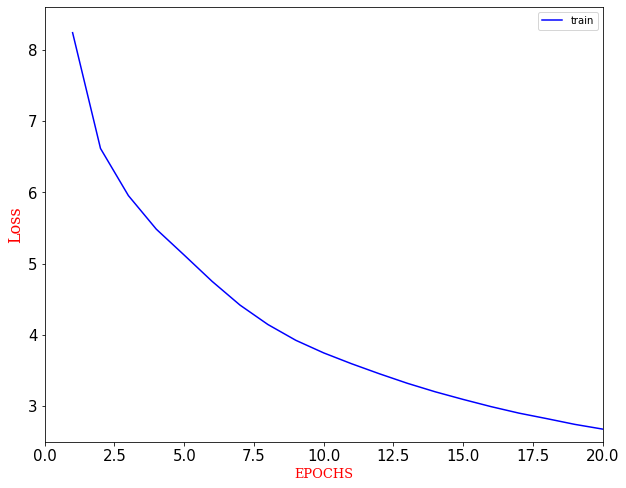

In [ ]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots( 1,1,figsize=(10,8))
colors = [ '#0000FF']
font1 = {'family':'serif','color':'red','size':13}
font2 = {'family':'serif','color':'red','size':16}

ax.plot(epochs, loss_1,color=colors[0],label='train')
ax.tick_params(labelsize=15)
#plt.title("News dataset", fontdict = font3)
ax.set_xlabel('EPOCHS', fontdict = font1)
ax.set_ylabel('Loss', fontdict = font2)
ax.legend()
ax.axis([0, 20,2.5, 8.6])
plt.savefig('loss_transformer.jpg')
plt.show()

In [ ]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index["<go>"]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(decoder_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index["<stop>"]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


In [ ]:
def summarize(input_document):
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0) 
    return summary_tokenizer.sequences_to_texts(summarized)[0]  

In [ ]:
random_=[]
for i in range(0,100):
    
    random = np.random.randint(0,1000)
    random_.append(random)
    print("Review:",inputs_[random])
    print("Original summary:",targets_[random])
    print("Predicted summary:",summarize(inputs_[random]))
    print("\n")
print(random_)

Review: the ministry of external affairs has termed akshay kumar starrer 39 airlift 39 a great film adding that it fell short on facts 34 the film has also taken a lot of artistic liberties in the depictions of the events that actually happened in kuwait in 1990 34 ministry spokesman vikas swarup said former ambassador nirupama rao has also termed the film as 39 biased 39
Original summary: 39 airlift 39 great but short of facts says mea
Predicted summary: 39 nation 39 trending on twitter today


Review: apple on wednesday posted its highest ever quarterly net income of 18 4 billion in the december quarter a 2 2 jump against the corresponding period last year revenue rose around 1 74 to a record 75 9 billion against the year ago period further apple sold a record 74 8 million iphones marginally higher than the 74 5 million sales in the same period last year
Original summary: apple posts highest ever quarterly net income
Predicted summary: apple posts highest quarterly revenue in an net 

In [ ]:
orgsum=[]
presum=[]
from rouge_score import rouge_scorer

for i in range(0,100):
  j=random_[i]
  #scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
  #scores1 = scorer.score(summarize(inputs_[j]),targets_[j])
  #scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
  #scores2 = scorer.score(summarize(inputs_[j]),targets_[j])
  #for key, value in scores2.items():
    #if (value.fmeasure  >= 0.5) and (value.recall  >= 0.5) and (value.precision  >= 0.5) :
  orgsum.append(targets_[j])
  presum.append(summarize(inputs_[j]))

In [ ]:
data_1 = pd.DataFrame({'Original summary':orgsum }) 
data_1.to_csv("Original_summary__.csv",index=False) 
Original_summary__=pd.read_csv("Original_summary__.csv")
Original_summary__.head()

,Original summary
0,39 airlift 39 great but short of facts says mea
1,apple posts highest ever quarterly net income
2,anti conversion law misused in mp archbishop
3,google street view adds 360° view of mont blanc
4,fipb clears 13 fdi proposals worth ₹6 500 cr


In [ ]:
with open("Original_summary__.csv", 'r') as inp, open('T20.txt', 'w') as out:
    for line in inp:
        out.write(line)

In [ ]:
data_2 = pd.DataFrame({"Predicted summary":presum}) 
data_2.to_csv("Predicted_summary__.csv",index=False) 
Predicted_summary__=pd.read_csv("Predicted_summary__.csv")
Predicted_summary__.head()

,Predicted summary
0,39 nation 39 trending on twitter today
1,apple posts highest quarterly revenue in an ne...
2,anti muslim law against dalit officers
3,google street view adds 360° view of 39 jungle 39
4,ongc videsh gets ₹6 100 cr in foreign fund


In [ ]:
with open("Predicted_summary__.csv", 'r') as inp, open('T__20.txt', 'w') as out:
    for line in inp:
        out.write(line)

In [ ]:
pip install rouge

In [ ]:
from rouge import FilesRouge
files_rouge = FilesRouge()
scores = files_rouge.get_scores( hyp_path="/content/drive/MyDrive/news/T20.txt", 
                                 ref_path='/content/drive/MyDrive/news/T__20.txt',
                                 avg=True)

EPOCHS 10


In [ ]:
key_=[]
value_=[]
for key, value in scores.items():
  print(key,value)
  key_.append(key)
  value_.append(value)

rouge-1 {'f': 0.3125569199194268, 'p': 0.3263365622276513, 'r': 0.3045998555899545}
rouge-2 {'f': 0.1309439351493545, 'p': 0.13492885002785987, 'r': 0.1293793665080794}
rouge-l {'f': 0.30506744620188836, 'p': 0.3068092523538067, 'r': 0.3109160916091608}


EPOCHS 15

In [ ]:
key_=[]
value_=[]
for key, value in scores.items():
  print(key,value)
  key_.append(key)
  value_.append(value)

rouge-1 {'f': 0.3424362638829445, 'p': 0.349188490277599, 'r': 0.34403654651179394}
rouge-2 {'f': 0.14659875741823572, 'p': 0.15274813195605272, 'r': 0.14615818724729615}
rouge-l {'f': 0.33514746416675056, 'p': 0.3314345720286313, 'r': 0.34547133284757037}


In [ ]:
key_=[]
value_=[]
for key, value in scores.items():
  print(key,value)
  key_.append(key)
  value_.append(value)

rouge-1 {'f': 0.39630956517246346, 'p': 0.40990884802765976, 'r': 0.3877327842674376}
rouge-2 {'f': 0.2107506149399543, 'p': 0.21724815338676715, 'r': 0.2067426797624817}
rouge-l {'f': 0.38563452885569205, 'p': 0.38757554326861243, 'r': 0.3904147557612903}


In [ ]:
rouge_1_transformer=[0,0.3125569199194268, 0.3424362638829445, 0.39630956517246346] 
rouge_2_transformer=[0,0.1309439351493545, 0.14659875741823572, 0.2107506149399543]
rouge_1_lstm=[0, 0.2262350351153508, 0.23455802628799766, 0.2817870087992989] 
rouge_2_lstm=[0, 0.07205284511783422, 0.06539359631948262, 0.082943486251831]
epc=["Rouge_1","Rouge_2","Rouge_L"]

In [ ]:
rouge_transformer=[ 0.39630956517246346,0.2107506149399543,0.38563452885569205]
rouge_lstm=[ 0.2817870087992989,0.082943486251831,0.27516594985675574]

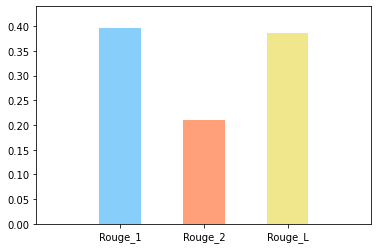

In [ ]:
transformer_=plt.bar(epc,rouge_1_transformer,color=['#87CEFA', '#FFA07A', '#F0E68C'], width = 0.5)
plt.axis([-1,3,0,0.44])
plt.savefig('rougeNewstransformer.jpg')
plt.show()


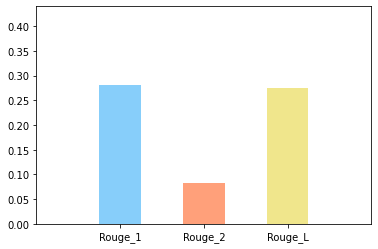

In [ ]:
_lstm=plt.bar(epc,rouge_lstm,color=['#87CEFA', '#FFA07A', '#F0E68C'], width = 0.5)
plt.axis([-1,3,0,0.44])
plt.savefig('rougeNewsLSTM.jpg')
plt.show()

AttributeError: ignored

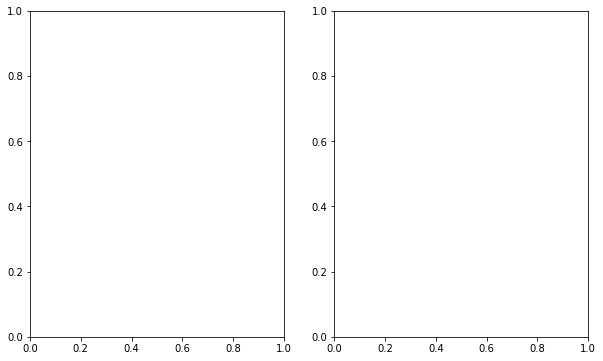

In [ ]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots( 1,1,figsize=(10,6))
colors = [ '#FF6347']
font1 = {'family':'serif','color':'red','size':13}
font2 = {'family':'serif','color':'red','size':16}
#u,=ax.plot(epc,rouge_l, marker = 'o')
v,=ax.bar(epc,rouge_1_transformer)
x,=ax.bar(epc,rouge_2_transformer, marker = 'o')
#u.set_label('  ROUGE-l   ')
v.set_label('  ROUGE-1   ')
x.set_label('  ROUGE-2   ')
#u.set_markersize(10)
v.set_markersize(10)
x.set_markersize(10)
ax.tick_params(labelsize=15)
#plt.title("News dataset", fontdict = font3)
ax.set_xlabel('EPOCHS', fontdict = font1)
ax.set_ylabel('ROUGE-L', fontdict = font2)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid()
ax.axis([0, 22,0.0, 0.44])
plt.savefig('rougeNews.jpg')
plt.show()

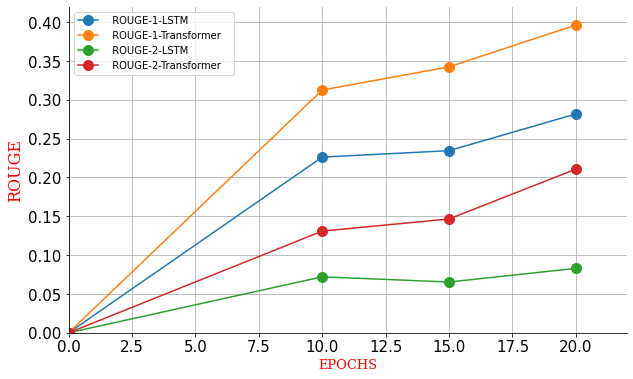

In [ ]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots( 1,1,figsize=(10,6))
colors = [ '#FF6347']
font1 = {'family':'serif','color':'red','size':13}
font2 = {'family':'serif','color':'red','size':16}
#u,=ax.plot(epc,rouge_l, marker = 'o')
v,=ax.plot(epc,rouge_1_lstm, marker = 'o')
f,=ax.plot(epc,rouge_1_transformer, marker = 'o')
x,=ax.plot(epc,rouge_2_lstm, marker = 'o')
e,=ax.plot(epc,rouge_2_transformer, marker = 'o')
#u.set_label('  ROUGE-l   ')
v.set_label('  ROUGE-1-LSTM   ')
f.set_label('  ROUGE-1-Transformer   ')
x.set_label('  ROUGE-2-LSTM   ')
e.set_label('  ROUGE-2-Transformer   ')
#u.set_markersize(10)
v.set_markersize(10)
x.set_markersize(10)
e.set_markersize(10)
f.set_markersize(10)
ax.tick_params(labelsize=15)
#plt.title("News dataset", fontdict = font3)
ax.set_xlabel('EPOCHS', fontdict = font1)
ax.set_ylabel('ROUGE', fontdict = font2)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid()
ax.axis([0, 22,0.0, 0.42])


plt.savefig('rougenews_lstm_trans.jpg')
plt.show()